# Caso de Negocio

`completar` 

# Importar, Instalar y Cargar

## Instalación de librerías 


Para mantener los entornos actualizados, se almacenan las librerías necesarias en un archivo de requerimientos. Para instalar las librerías necesarias, se ejecuta el siguiente comando:

```bash
# Creación de archivo de requerimientos
pip freeze > requirements.txt
```

```bash
# Instalación de librerías necesarias
pip install -r requirements.txt
```

## Importar librerías

In [13]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
from sklearn.cluster import KMeans
from skimage import io, img_as_float
from scipy.ndimage import median_filter
import numpy as np

## Cargar Las Imagenes

In [15]:
image_directory = "base"
images = []

for filename in os.listdir(image_directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img = Image.open(os.path.join(image_directory, filename))
        images.append((filename, img))

## Cargar Bounding Boxes

In [16]:
with open('classificationDownload/classifications.json', 'r') as file:
    bounding_boxes = json.load(file)   

# Análisis Exploratorio de Datos

## Análisis del CSV

In [66]:
import pandas as pd
from ydata_profiling import ProfileReport

# Cargar el archivo CSV
df = pd.read_csv('classificationDownload/classifications.csv')

# Generar el reporte de EDA
profile = ProfileReport(df, title="EDA Report")

# Mostrar el reporte directamente en la celda del notebook
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


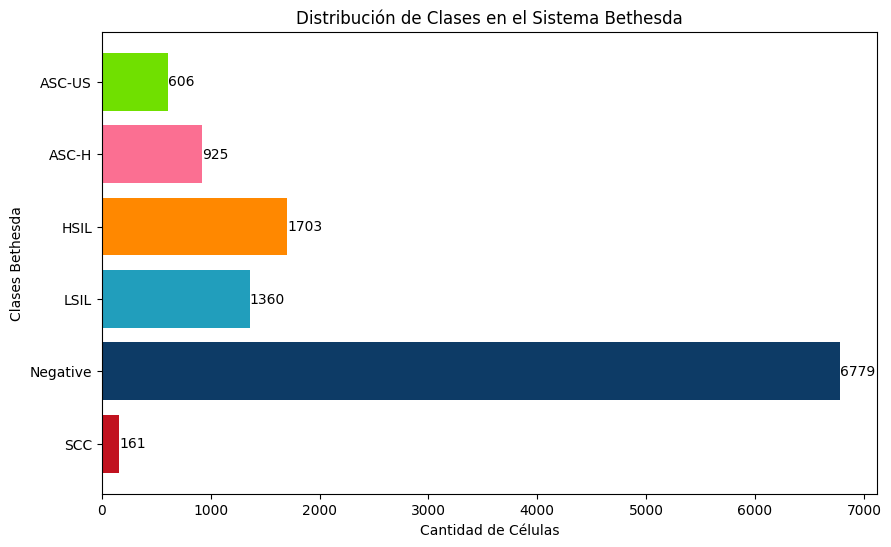

In [67]:
import json
import matplotlib.pyplot as plt

# Cargar los bounding boxes desde el archivo JSON
with open('classificationDownload/classifications.json', 'r') as file:
    bounding_boxes = json.load(file)

# Contar el número de instancias por clase Bethesda
class_counts = {}

for entry in bounding_boxes:
    classifications = entry['classifications']
    for classification in classifications:
        bethesda_system = classification['bethesda_system']
        
        # Ajustar el nombre de la clase "Negative for intraepithelial lesion" a "Negative"
        if bethesda_system == "Negative for intraepithelial lesion":
            bethesda_system = "Negative"
        
        if bethesda_system in class_counts:
            class_counts[bethesda_system] += 1
        else:
            class_counts[bethesda_system] = 1

# Colores asignados a cada clase Bethesda, con un color por defecto (gris) para clases no asignadas
class_colors = {
    'SCC': '#c1121f',  # Rojo
    'ASC-US': '#70e000',  # Verde
    'LSIL': '#219ebc',  # Celeste
    'HSIL': '#ff8800',  # Naranja
    'Negative': '#0d3b66',  # Negro
    'ASC-H': '#fb6f92'  # Rosa
}

# Preparar los datos para el gráfico de barras
labels = list(class_counts.keys())
sizes = list(class_counts.values())

# Asignar colores a cada barra según la clase o un color por defecto si no existe en el diccionario
colors = [class_colors.get(label, '#cccccc') for label in labels]  # Gris claro por defecto

# Gráfico de Barras Horizontal con colores personalizados
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, sizes, color=colors)

# Añadir el número de células dentro de cada barra
for bar, size in zip(bars, sizes):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,  # Posición
             str(size),  # Texto (número de células)
             va='center', ha='left', fontsize=10)  # Alineación vertical y horizontal

plt.title('Distribución de Clases en el Sistema Bethesda')
plt.xlabel('Cantidad de Células')
plt.ylabel('Clases Bethesda')
plt.show()

**Desbalance de Clases**

La clase con celulas `Negativas de lesiones intraepitelial`  domina claramente el dataset, representando la mayor proporción de células. Esto sugiere un desbalance significativo en el dataset.
Este desbalance puede afectar los modelos de clasificación. Los modelos pueden aprender a favorecer la clase dominante, lo que podría llevar a una clasificación incorrecta o baja precisión en las clases menos representadas.

## Análisis de Datos

### Bounding Box Tamaño Fijo 90x90

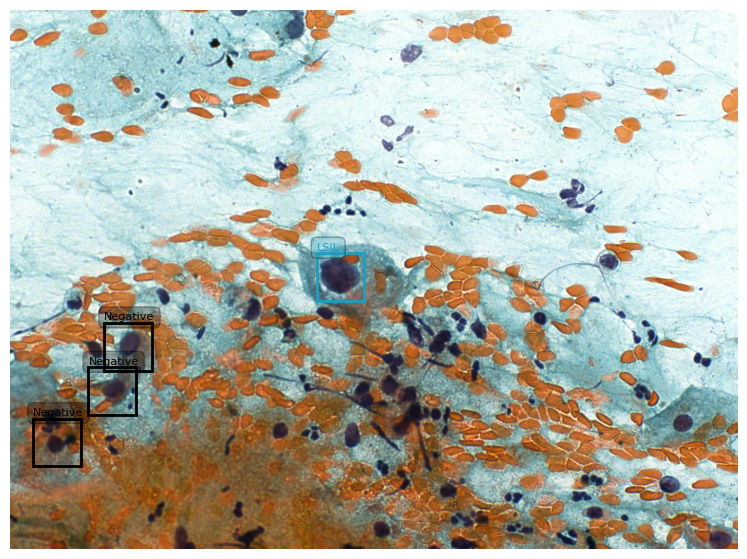

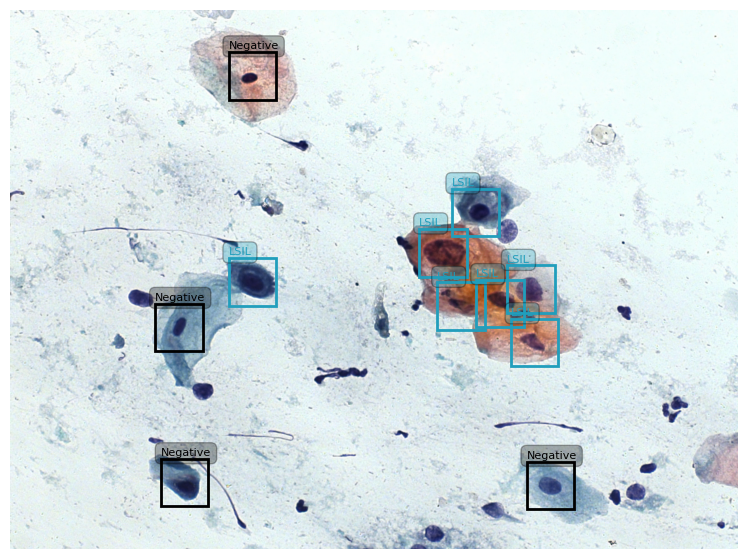

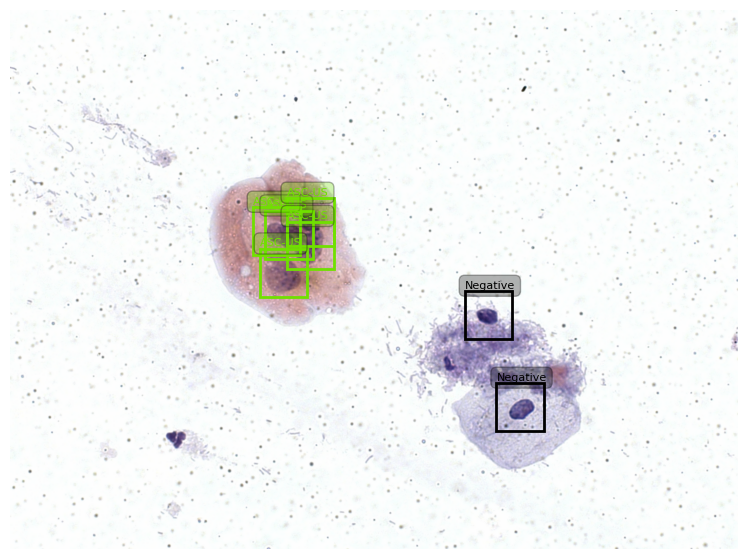

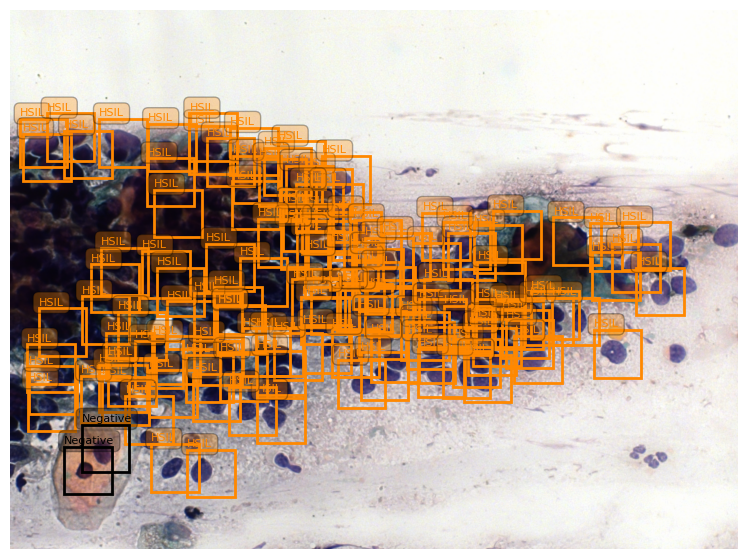

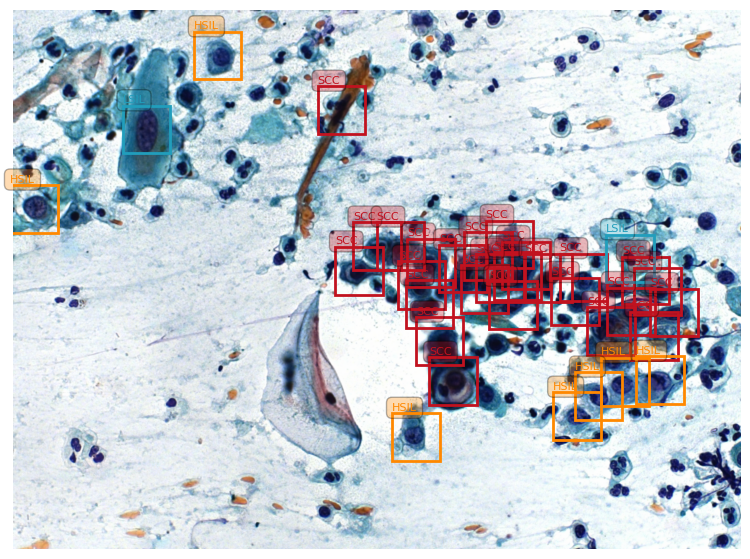

In [55]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image

# Cargar las imágenes desde el directorio
image_directory = "base"
images = []

for filename in os.listdir(image_directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img = Image.open(os.path.join(image_directory, filename))
        images.append((filename, img))

# Limitar a las primeras 5 imágenes
images = images[:5]

# Cargar los bounding boxes desde el archivo JSON
with open('classificationDownload/classifications.json', 'r') as file:
    bounding_boxes = json.load(file)

# Diccionario de colores para clases
class_colors = {
    'SCC': '#c1121f',  # Rojo
    'ASC-US': '#70e000',  # Verde
    'LSIL': '#219ebc',  # Celeste
    'HSIL': '#ff8800',  # Naranja
    'ASC-H': '#fb6f92',  # Rosa
    'Negative for intraepithelial lesion': '#0d3b66',  # Azul Oscuro
}

# Función para ajustar el nombre de la clase "Negative for intraepithelial lesion" a "Negative"
def adjust_class_name(bethesda_system):
    if bethesda_system == 'Negative for intraepithelial lesion':
        return 'Negative'
    return bethesda_system

# Función para dibujar bounding boxes de tamaño fijo 90x90 píxeles con colores específicos
def draw_fixed_bounding_boxes(img, classifications):
    fig, ax = plt.subplots(1, figsize=(10, 7))
    ax.imshow(img)
    
    rect_width, rect_height = 90, 90  # Tamaño fijo del bounding box (90x90 píxeles)
    
    for classification in classifications:
        x_center = classification['nucleus_x']
        y_center = classification['nucleus_y']
        bethesda_system = adjust_class_name(classification['bethesda_system'])  # Ajustar nombre de clase
        
        # Calcular la esquina superior izquierda del bounding box
        x = x_center - rect_width / 2
        y = y_center - rect_height / 2
        
        # Obtener el color para la clase bethesda_system
        color = class_colors.get(bethesda_system, 'black')  # Usa 'black' si la clase no tiene color asignado
        
        # Dibujar el bounding box en la imagen
        rect = plt.Rectangle((x, y), rect_width, rect_height, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Etiquetar el bounding box solo con la clase
        label = bethesda_system  # Solo mostrar la clase
        ax.text(x, y - 5, label, color=color, fontsize=8, bbox=dict(facecolor=color, alpha=0.3, pad=1, boxstyle='round,pad=0.5'))

    plt.axis('off')
    plt.show()

# Aplicar la función a las primeras 5 imágenes
for image_name, img in images:
    # Buscar las clasificaciones correspondientes a la imagen
    for entry in bounding_boxes:
        if entry['image_name'] == image_name:
            classifications = entry['classifications']
            draw_fixed_bounding_boxes(img, classifications)
            break

La imagen muestra una superposición de bounding boxes, lo que puede afectar la precisión de la clasificación al incluir múltiples células en una misma caja y usar tamaños fijos para los núcleos, que varían en tamaño.

Ideas de mejora:

	1.	Clasificación de clusters: Utilizar algoritmos como DBSCAN para agrupar células cercanas o solapadas y clasificarlas como un grupo.
	2.	Bounding boxes adaptativas: Ajustar el tamaño de las cajas según el tamaño real del núcleo, mejorando la precisión de la segmentación.
	3.	Filtrado de cajas duplicadas: Implementar técnicas como Non-Maximum Suppression (NMS) para eliminar bounding boxes redundantes.
	4.	Mejor segmentación: Usar técnicas como watershed para separar claramente los núcleos cercanos y evitar solapamientos.

### Segmentación y Detección de Bounding Boxes Precisas para Células `en proceso`

**Paso 1: Preprocesamiento de la Imagen**

In [7]:
def preprocess_image(image):
    # Convertir la imagen de PIL a array de NumPy
    img_np = np.array(image)
    
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    
    # Aplicar un filtro Gaussiano para suavizar la imagen
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    
    # Operación morfológica de apertura para eliminar el ruido
    kernel = np.ones((3,3), np.uint8)
    morph_image = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Mostrar la imagen preprocesada
    plt.figure()
    plt.imshow(morph_image, cmap='gray')
    plt.title('Imagen Preprocesada (Blureo + Operaciones Morfológicas)')
    plt.show()
    
    return morph_image

**Paso 2: Clustering con K-Means**

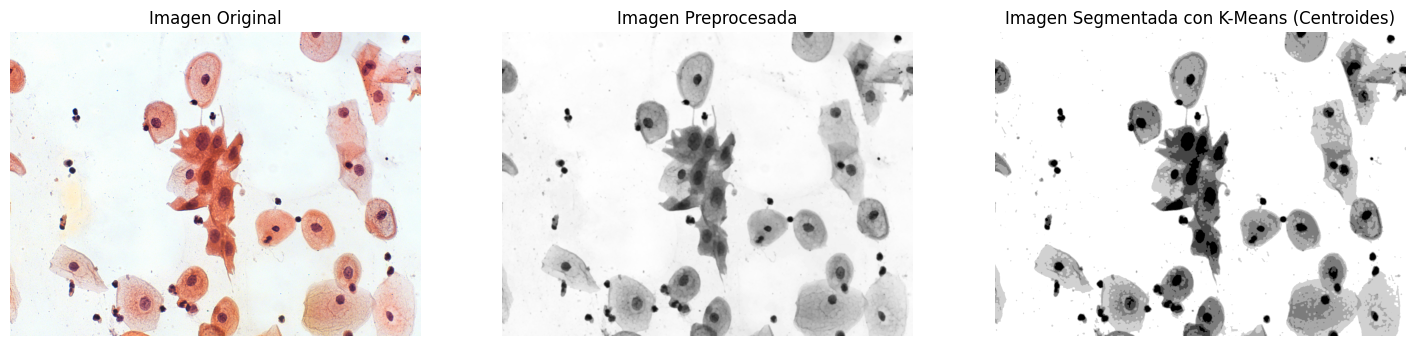

In [8]:
def preprocess_image(image):
    # Convertir la imagen de PIL a array de NumPy
    img_np = np.array(image)
    
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    
    # Aplicar un filtro Gaussiano para suavizar la imagen
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    
    # Operación morfológica de apertura para eliminar el ruido
    kernel = np.ones((3,3), np.uint8)
    morph_image = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return morph_image

def kmeans_clustering(image, k=3):
    # Reestructurar la imagen a un array 2D de píxeles
    pixel_values = image.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)
    
    # Definir los criterios de K-means (10 iteraciones, precisión de 1.0)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    # Aplicar K-means
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convertir los centros de los clusters de nuevo a escala de grises
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    
    # Reestructurar la imagen segmentada a las dimensiones originales
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image, labels.reshape(image.shape)

def visualize_side_by_side(original_image, preprocessed_image, segmented_image):
    # Crear una figura con tres subplots, uno para la imagen original, otro para la preprocesada, y otro para la segmentada
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Mostrar la imagen original
    axes[0].imshow(original_image)
    axes[0].set_title("Imagen Original")
    axes[0].axis('off')
    
    # Mostrar la imagen preprocesada
    axes[1].imshow(preprocessed_image, cmap='gray')
    axes[1].set_title("Imagen Preprocesada")
    axes[1].axis('off')
    
    # Mostrar la imagen segmentada utilizando los valores de los centroides
    axes[2].imshow(segmented_image, cmap='gray')
    axes[2].set_title("Imagen Segmentada con K-Means (Centroides)")
    axes[2].axis('off')
    
    # Mostrar la figura completa
    plt.show()

# Ejemplo de uso con la imagen específica que cargaste
image_name = '00b1e59ebc3e7be500ef7548207d44e2.png'
image_path = 'base/00b1e59ebc3e7be500ef7548207d44e2.png'
img = Image.open(image_path)

# Paso 1: Preprocesar la imagen
preprocessed_image = preprocess_image(img)

# Paso 2: Aplicar clustering con K-Means
segmented_image, labels = kmeans_clustering(preprocessed_image, k=6)

# Visualizar las imágenes lado a lado
visualize_side_by_side(img, preprocessed_image, segmented_image)

Centroides: [119 156  75 245 185 213]
Cluster menos saturado seleccionado: 2


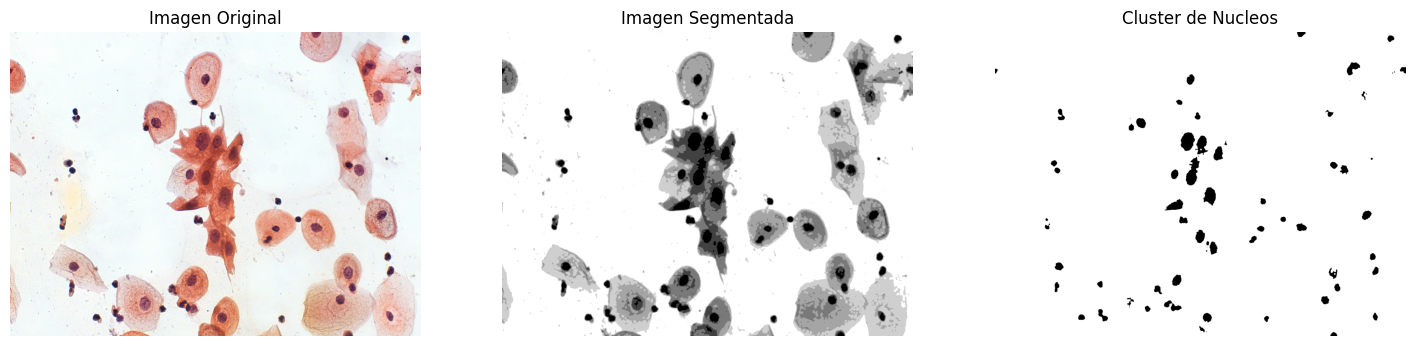

In [9]:
def preprocess_image(image):
    # Convertir la imagen de PIL a array de NumPy
    img_np = np.array(image)
    
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    
    # Aplicar un filtro Gaussiano para suavizar la imagen
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    
    # Operación morfológica de apertura para eliminar el ruido
    kernel = np.ones((3,3), np.uint8)
    morph_image = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return morph_image

def kmeans_clustering(image, k=6):
    # Reestructurar la imagen a un array 2D de píxeles
    pixel_values = image.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)
    
    # Definir los criterios de K-means (10 iteraciones, precisión de 1.0)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    # Aplicar K-means
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convertir los centros de los clusters de nuevo a escala de grises
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    
    # Reestructurar la imagen segmentada a las dimensiones originales
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image, labels.reshape(image.shape), centers

def isolate_least_saturated_cluster(segmented_image, labels, centers):
    # Identificar el centroide más bajo (menos saturado)
    least_saturated_cluster = np.argmin(centers)
    
    # Verificación: Imprimir los valores de los centroides y el cluster seleccionado
    print("Centroides:", centers.flatten())
    print("Cluster menos saturado seleccionado:", least_saturated_cluster)
    
    # Crear una máscara binaria donde el cluster seleccionado es blanco (255) y el resto negro (0)
    mask = (labels == least_saturated_cluster).astype(np.uint8) * 255
    
    # Invertir la máscara para que el cluster seleccionado sea negro (0) y lo demás sea blanco (255)
    isolated_image = cv2.bitwise_not(mask)
    
    return isolated_image

def visualize_images(original_image, segmented_image, isolated_image):
    # Crear una figura con tres subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Mostrar la imagen original
    axes[0].imshow(original_image)
    axes[0].set_title("Imagen Original")
    axes[0].axis('off')
    
    # Mostrar la imagen segmentada
    axes[1].imshow(segmented_image, cmap='gray')
    axes[1].set_title("Imagen Segmentada")
    axes[1].axis('off')
    
    # Mostrar la imagen con el cluster menos saturado en negro
    axes[2].imshow(isolated_image, cmap='gray')
    axes[2].set_title("Cluster de Nucleos")
    axes[2].axis('off')
    
    # Mostrar la figura completa
    plt.show()

# Ejemplo de uso con la imagen específica que cargaste
image_name = '00b1e59ebc3e7be500ef7548207d44e2.png'
image_path = 'base/00b1e59ebc3e7be500ef7548207d44e2.png'
img = Image.open(image_path)

# Paso 1: Preprocesar la imagen
preprocessed_image = preprocess_image(img)

# Paso 2: Aplicar clustering con K-Means
segmented_image, labels, centers = kmeans_clustering(preprocessed_image, k=6)

# Paso 3: Aislar el cluster menos saturado y mostrarlo en negro
isolated_image = isolate_least_saturated_cluster(segmented_image, labels, centers)

# Paso 4: Visualizar las imágenes
visualize_images(img, segmented_image, isolated_image)

Centroides: [119 156  75 245 185 213]
Cluster menos saturado seleccionado: 2


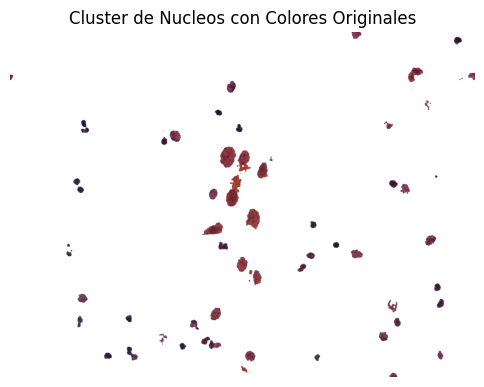

In [10]:
# Asegúrate de que `img_np` es la imagen en formato NumPy, no el nombre de la imagen
img_np = np.array(img)  # Si `img` es la imagen PIL cargada, convertimos a NumPy

# Paso 1: Utiliza la función existente para obtener el cluster menos saturado
isolated_image_mask = isolate_least_saturated_cluster(img_np, labels, centers)

# Paso 2: Convertir la imagen en blanco y negro en una máscara binaria
mask = (isolated_image_mask == 0).astype(np.uint8)

# Paso 3: Crear una imagen en blanco del mismo tamaño que la original
colored_isolated_image = np.ones_like(img_np) * 255

# Paso 4: Aplicar la máscara a la imagen original para mantener solo los colores del cluster menos saturado
colored_isolated_image[mask == 1] = img_np[mask == 1]

# Paso 5: Visualizar la imagen con el cluster menos saturado y colores originales
plt.figure(figsize=(6, 6))
plt.imshow(colored_isolated_image)
plt.title("Cluster de Nucleos con Colores Originales")
plt.axis('off')
plt.show()

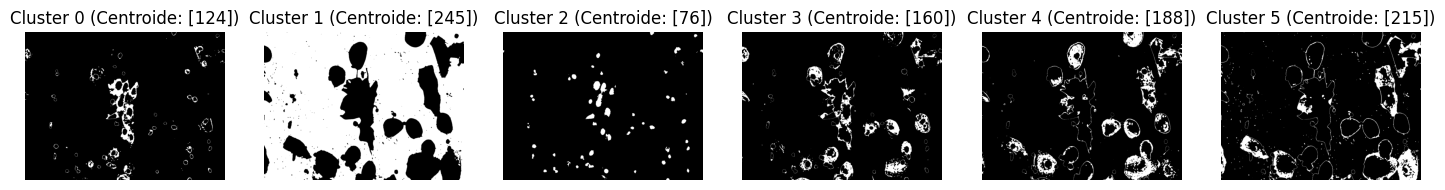

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

def preprocess_image(image):
    # Convertir la imagen de PIL a array de NumPy
    img_np = np.array(image)
    
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    
    # Aplicar un filtro Gaussiano para suavizar la imagen
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    
    # Operación morfológica de apertura para eliminar el ruido
    kernel = np.ones((3,3), np.uint8)
    morph_image = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return morph_image

def kmeans_clustering(image, k=6):
    # Reestructurar la imagen a un array 2D de píxeles
    pixel_values = image.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)
    
    # Definir los criterios de K-means (10 iteraciones, precisión de 1.0)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    # Aplicar K-means
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convertir los centros de los clusters de nuevo a escala de grises
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    
    # Reestructurar la imagen segmentada a las dimensiones originales
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image, labels.reshape(image.shape), centers

def visualize_clusters_separately(segmented_image, labels, centers):
    k = len(centers)
    fig, axes = plt.subplots(1, k, figsize=(18, 6))
    
    for i in range(k):
        # Crear una máscara para el cluster i
        mask = (labels == i).astype(np.uint8) * 255
        
        # Aplicar la máscara a la imagen segmentada para visualizar solo el cluster i
        isolated_image = cv2.bitwise_and(segmented_image, segmented_image, mask=mask)
        
        # Mostrar el cluster i
        axes[i].imshow(isolated_image, cmap='gray')
        axes[i].set_title(f"Cluster {i} (Centroide: {centers[i]})")
        axes[i].axis('off')
    
    plt.show()

# Ejemplo de uso con la imagen específica que cargaste
image_name = '00b1e59ebc3e7be500ef7548207d44e2.png'
image_path = 'base/00b1e59ebc3e7be500ef7548207d44e2.png'
img = Image.open(image_path)

# Paso 1: Preprocesar la imagen
preprocessed_image = preprocess_image(img)

# Paso 2: Aplicar clustering con K-Means
segmented_image, labels, centers = kmeans_clustering(preprocessed_image, k=6)

# Paso 3: Visualizar cada cluster por separado
visualize_clusters_separately(segmented_image, labels, centers)


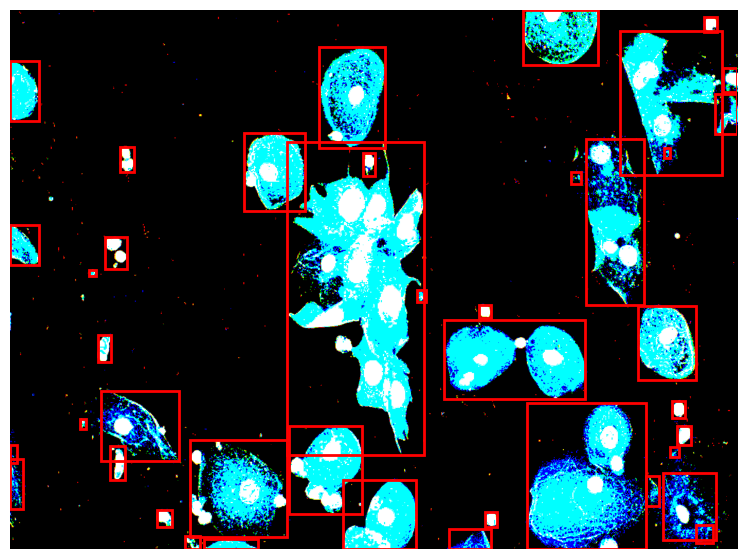

In [81]:
# Intentemos nuevamente asegurándonos que el proceso de detección de contornos funcione bien.
def process_segmented_image_for_nuclei(segmented_image):
    # Convertir la imagen segmentada a escala de grises si es necesario
    if len(segmented_image.shape) == 3:  # Si la imagen es en color (RGB)
        gray = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)
    else:
        gray = segmented_image  # Si ya está en escala de grises
    
    # Aplicar un umbral para obtener una imagen binaria
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    # Aplicar operaciones morfológicas para limpiar ruido
    kernel = np.ones((3, 3), np.uint8)
    cleaned_image = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    return cleaned_image

# Función para detectar contornos y generar bounding boxes precisos
def detect_nuclei_and_create_bounding_boxes(segmented_image):
    fig, ax = plt.subplots(1, figsize=(10, 7))
    ax.imshow(segmented_image, cmap='gray')  # Mostramos la imagen aislada de núcleos en escala de grises
    
    # Convertir la imagen segmentada a escala de grises y binarizar
    cleaned_image = process_segmented_image_for_nuclei(segmented_image)
    
    # Detección de contornos en la imagen binaria
    contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        # Calcular el bounding box para cada contorno
        x, y, w, h = cv2.boundingRect(contour)
        
        # Dibujar el bounding box solo si es de un tamaño razonable
        if w > 10 and h > 10:  # Evitar contornos muy pequeños o ruidos
            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Procesar y detectar núcleos en los tres clusters menos saturados
detect_nuclei_and_create_bounding_boxes(three_clusters_mask)

# Bibliografía